<a href="https://colab.research.google.com/github/dyou-wbg/meta_processing/blob/main/0501_Annotation_2KPair_matchingWordLength_poolingfrom11M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from google.colab import drive
import csv
import os
import re
import pandas as pd
import numpy as np

directory = '/content/drive/MyDrive/finalMetaFile'
df = pd.read_csv(os.path.join(directory, 'combined_metadata_final12_features.csv'))
df=df[['sourcename', 'title']]
df.head()

Mounted at /content/drive


In [ ]:
unique_sources = df['sourcename'].unique()
print(unique_sources)


['metadata_jstor_unifiedColName.csv'
 'scopus_fixed_encoding_unifiedColName.csv'
 'elsevier_metadata_unifiedColName.csv'
 'metadata_semantic_scholar_unifiedColName.csv'
 'url1_ie_table_complete_unifiedColName.csv'
 'metadata_econlit_unifiedColName.csv' 'SSRN_metadata_unifiedColName.csv'
 'metadata_repec_unifiedColName.csv']


In [ ]:
df['sourcename'] = df['sourcename'].apply(lambda x: x.replace('metadata_', ''))
df['sourcename'] = df['sourcename'].apply(lambda x: x.replace('_unifiedColName.csv', ''))
df['sourcename'].replace(['url1_ie_table_complete', 'scopus_fixed_encoding','SSRN'], ['3ie', 'scopus','ssrn'], inplace=True)


In [ ]:
unique_sources = df['sourcename'].unique()
print(unique_sources)

['jstor' 'scopus' 'elsevier' 'semantic_scholar' '3ie' 'econlit' 'ssrn'
 'repec']


In [ ]:
def count_words(title):
  words = title.split()
  return len(words)
df['title'] = df['title'].astype(str)
df['word_count'] = df['title'].apply(count_words)


min=5
max=20

df_min_max = df[(df['word_count'] >= min) & (df['word_count'] <= max)]

In [ ]:
import math
math.sqrt(2000)

44.721359549995796

In [ ]:
150*0.3

45.0

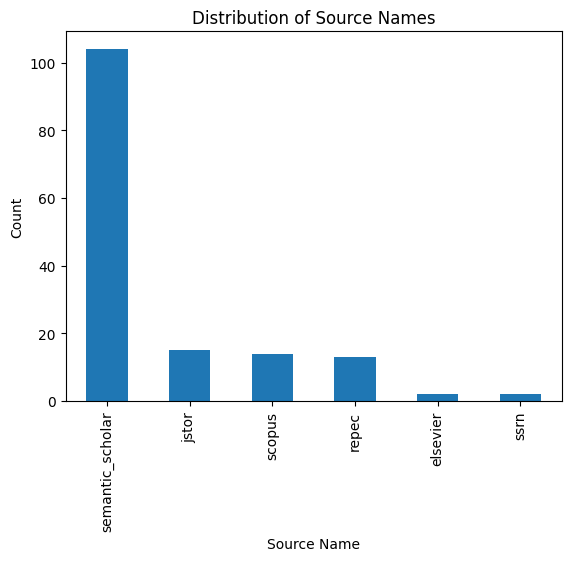

In [ ]:
# we need 2K pair. before pair should be sqrt(2000) = 45
# we need enough to make a pair that is with matching word length (30% of them are around similar length)
# (0.3*n)= 45
# n = 150
title_sample_size= 150 #

def sample_dataframe(df, sample_size):
  if len(df) > sample_size:
    return df.sample(n=sample_size, random_state=321)
  else:
    return df
df_min_max = sample_dataframe(df_min_max, title_sample_size)

import matplotlib.pyplot as plt

df_min_max['sourcename'].value_counts().plot(kind='bar')
plt.xlabel('Source Name')
plt.ylabel('Count')
plt.title('Distribution of Source Names')
plt.show()

Outcome pair is reperesenting true distribution in the 11M titles. It is not balanced pair from each sources.

In [ ]:
 #prep to make a pair

from string import printable
from collections import Counter

printable_dict = {c:i for i,c in enumerate(printable)}

def vectorize(title):
    cnt = Counter(title)
    array = [0 for _ in printable]+[0]
    for c,n in cnt.items():
        if c in printable_dict:
            array[printable_dict[c]]=n
        else:
            array[-1]+=n
    return np.array(array)

vects = []
for title in df_min_max.title:
    vects.append(vectorize(title))

In [ ]:
threshold = 1000 # force very high to return all possible pair
min_length = 5 # was 10 but change to 5 to keep all sampled titles


with open('/content/drive/MyDrive/finalMetaFile/counterVect_L1_2kPair_annotation_pooledFrom11MNotbalancedSources.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Title 1", "Title 2", "Similarity Score"])
# Iterate over title pairs
  for i, v1 in enumerate(vects):
    if sum(v1[:-1]) > min_length: # Only above a minimum number of printable characters
        for j, v2 in enumerate(vects):
            if sum(v2[:-1]) > min_length:
                if i!=j:
                    l1 = np.linalg.norm((v1[:-1] - v2[:-1]), ord=1)
                    if l1 < threshold:
                        t1 = df_min_max.iloc[i].title
                        t2 = df_min_max.iloc[j].title
                        writer.writerow([t1, t2, l1])
                        #print(f"{t1} _&_ {t2} (L1: {l1:.0f})")

In [ ]:
df_annotation_simialrLength = pd.read_csv(os.path.join(directory, 'counterVect_L1_1MPair_annotation_similarLengthTitleUpto3Words.csv'))
df_annotation_simialrLength['annotation_label']=0
df_annotation_simialrLength.head()

,Title 1,Title 2,Similarity Score,annotation_label
0,determinants of school enrolment in indonesia:...,transportation infrastructure and productivity...,56.0,0
1,determinants of school enrolment in indonesia:...,sexual risk behavior among hiv-infected women ...,38.0,0
2,determinants of school enrolment in indonesia:...,measuring the net benefits of payments for hyd...,30.0,0
3,determinants of school enrolment in indonesia:...,are smart cities more ecologically efficient? ...,32.0,0
4,determinants of school enrolment in indonesia:...,policy cognition is more effective than step t...,51.0,0


In [ ]:
df_annotation_simialrLength['annotation_label'] = df_annotation_simialrLength.apply(lambda row: 1 if row['Title 1'] == row['Title 2'] else 0, axis=1)
df_annotation_simialrLength['annotation_label'].sum()/len(df_annotation_simialrLength)

2.002002002002002e-06

In [ ]:
def count_words(title):
  words = title.split()
  return len(words)

df_annotation_simialrLength['word_count_Title1'] = df_annotation_simialrLength['Title 1'].apply(count_words)
df_annotation_simialrLength['word_count_Title2'] = df_annotation_simialrLength['Title 2'].apply(count_words)


In [ ]:
df_annotation_simialrLength_matched = df_annotation_simialrLength.drop(df_annotation_simialrLength.loc[(abs(df_annotation_simialrLength['word_count_Title1'] - df_annotation_simialrLength['word_count_Title2']) >= 3)].index)


In [ ]:
len(df_annotation_simialrLength_matched)/len(df_annotation_simialrLength)

0.3638298298298298

In [ ]:
df_annotation_simialrLength_matched[df_annotation_simialrLength_matched['annotation_label']==1]

,Title 1,Title 2,Similarity Score,annotation_label,word_count_Title1,word_count_Title2
71190,direct democracy and resource allocation: expe...,direct democracy and resource allocation: expe...,0.0,1,9,9
261809,direct democracy and resource allocation: expe...,direct democracy and resource allocation: expe...,0.0,1,9,9


In [ ]:
df_annotation_simialrLength_matched.to_csv(os.path.join(directory, 'counterVect_L1_2kPair_annotation_similarLengthTitleUpto3Words_pooledFrom11MNotbalancedSources.csv'), index=False)

In [ ]:
df_min_max_with_source_name = df_min_max.copy()
df_min_max_with_source_name = df_min_max_with_source_name.rename(columns={'sourcename': 'sourcename_title1'})
df_min_max_with_source_name = df_min_max_with_source_name.rename(columns={'title': 'Title 1'})
df_min_max_with_source_name.drop(columns=['word_count'], inplace=True)


df_min_max_with_source_name.head()

,sourcename_title1,Title 1
7258987,semantic_scholar,Barriers to Adoption of B2B E-marketplaces: An...
375921,jstor,Condiciones del trabajo estudiantil urbano y a...
6271934,semantic_scholar,Public Participation and Institutional Fit: A ...
3689233,semantic_scholar,The Policy Implications of Economic Complexity
3451176,semantic_scholar,Unpacking Widow Headship and Agency in Post-Co...


In [ ]:
df_annotation_simialrLength_matched_with_source_name = df_annotation_simialrLength_matched.copy()
df_annotation_simialrLength_matched_with_source_name = df_annotation_simialrLength_matched_with_source_name.rename(columns={'title': 'Title 1'})

df_annotation_simialrLength_matched_with_source_name.head()

,Title 1,Title 2,Similarity Score,annotation_label,word_count_Title1,word_count_Title2
1,determinants of school enrolment in indonesia:...,sexual risk behavior among hiv-infected women ...,38.0,0,11,12
2,determinants of school enrolment in indonesia:...,measuring the net benefits of payments for hyd...,30.0,0,11,12
3,determinants of school enrolment in indonesia:...,are smart cities more ecologically efficient? ...,32.0,0,11,9
6,determinants of school enrolment in indonesia:...,adaptation to climate change in afghanistan: e...,42.0,0,11,13
11,determinants of school enrolment in indonesia:...,non-monetary incentives for tobacco prevention...,32.0,0,11,9


In [ ]:
df_joined = df_annotation_simialrLength_matched_with_source_name.merge(df_min_max_with_source_name, left_on='Title 1', right_on='Title 1', how='left')
df_joined.head()

,Title 1,Title 2,Similarity Score,annotation_label,word_count_Title1,word_count_Title2,sourcename_title1
0,determinants of school enrolment in indonesia:...,sexual risk behavior among hiv-infected women ...,38.0,0,11,12,NaN
1,determinants of school enrolment in indonesia:...,measuring the net benefits of payments for hyd...,30.0,0,11,12,NaN
2,determinants of school enrolment in indonesia:...,are smart cities more ecologically efficient? ...,32.0,0,11,9,NaN
3,determinants of school enrolment in indonesia:...,adaptation to climate change in afghanistan: e...,42.0,0,11,13,NaN
4,determinants of school enrolment in indonesia:...,non-monetary incentives for tobacco prevention...,32.0,0,11,9,NaN


In [ ]:
# prompt: merge title from df_min_max to df_annotation_simialrLength_matched_with_source_name'title and just keep sourcename and call it sourcename_title1

df_annotation_simialrLength_matched_with_source_name = df_annotation_simialrLength_matched_with_source_name.merge(df_min_max_with_source_name, left_on='title1', right_on='title', how='left')
df_annotation_simialrLength_matched_with_source_name = df_annotation_simialrLength_matched_with_source_name.merge(df_min_max_with_source_name, left_on='title2', right_on='title', how='left')
df_annotation_simialrLength_matched_with_source_name = df_annotation_simialrLength_matched_with_source_name.rename(columns={'sourcename_title1_x': 'sourcename_title1', 'sourcename_title1_y': 'sourcename_title2'})
df_annotation_simialrLength_matched_with_source_name.drop(['title_x', 'title_y'], axis=1, inplace=True)
df_annotation_simialrLength_matched_with_source_name.head()


KeyError: 'title1'

In [ ]:

# Filter the DataFrame by sourcename.
df_3ie = df[df['sourcename'] == '3ie']
df_econlit = df[df['sourcename'] == 'econlit']
df_ssrn = df[df['sourcename'] == 'ssrn']
df_elsevier = df[df['sourcename'] == 'elsevier']
df_repec = df[df['sourcename'] == 'repec']
df_scopus = df[df['sourcename'] == 'scopus']
df_jstor = df[df['sourcename'] == 'jstor']
df_semantic_scholar = df[df['sourcename'] == 'semantic_scholar']
df_repec = df_repec[df_repec['word_count'] < 1000]

In [ ]:
min=5
max=20

df_3ie_min_max = df_3ie[(df_3ie['word_count'] >= min) & (df_3ie['word_count'] <= max)]
df_econlit_min_max = df_econlit[(df_econlit['word_count'] >= min) & (df_econlit['word_count'] <= max)]
df_ssrn_min_max = df_ssrn[(df_ssrn['word_count'] >= min) & (df_ssrn['word_count'] <= max)]
df_elsevier_min_max = df_elsevier[(df_elsevier['word_count'] >= min) & (df_elsevier['word_count'] <= max)]
df_repec_min_max = df_repec[(df_repec['word_count'] >= min) & (df_repec['word_count'] <= max)]
df_scopus_min_max = df_scopus[(df_scopus['word_count'] >= min) & (df_scopus['word_count'] <= max)]
df_jstor_min_max = df_jstor[(df_jstor['word_count'] >= min) & (df_jstor['word_count'] <= max)]
df_semantic_scholar_min_max = df_semantic_scholar[(df_semantic_scholar['word_count'] >= min) & (df_semantic_scholar['word_count'] <= max)]

def sample_dataframe(df, sample_size):
  if len(df) > sample_size:
    return df.sample(n=sample_size)
  else:
    return df

import math

# update this part to get enough of match for word length. Previous trial was 2k pair and 30% of them had a matching title length +/- 3 words. We need triple of them.
title_sample_size=round(math.sqrt(6000)/8)

df_3ie_min_max = sample_dataframe(df_3ie_min_max, title_sample_size)
df_econlit_min_max = sample_dataframe(df_econlit_min_max, title_sample_size)
df_ssrn_min_max = sample_dataframe(df_ssrn_min_max, title_sample_size)
df_elsevier_min_max = sample_dataframe(df_elsevier_min_max, title_sample_size)
df_repec_min_max = sample_dataframe(df_repec_min_max, title_sample_size)
df_scopus_min_max = sample_dataframe(df_scopus_min_max, title_sample_size)
df_jstor_min_max = sample_dataframe(df_jstor_min_max, title_sample_size)
df_semantic_scholar_min_max = sample_dataframe(df_semantic_scholar_min_max, title_sample_size)

df_make_pair = pd.concat([df_3ie_min_max, df_econlit_min_max, df_ssrn_min_max, df_elsevier_min_max, df_repec_min_max, df_scopus_min_max, df_jstor_min_max, df_semantic_scholar_min_max])

#df_make_pair.to_csv(os.path.join(directory, 'combined_metadata_final12_features_MakePair_annotation.csv'), index=False)

In [ ]:
len(df_make_pair)

80

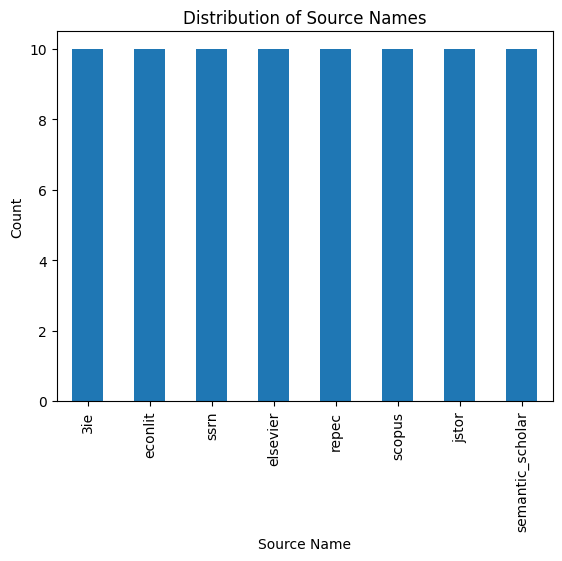

In [ ]:
import matplotlib.pyplot as plt

df_make_pair['sourcename'].value_counts().plot(kind='bar')
plt.xlabel('Source Name')
plt.ylabel('Count')
plt.title('Distribution of Source Names')
plt.show()

In [ ]:
# prep to make a pair

from string import printable
from collections import Counter

printable_dict = {c:i for i,c in enumerate(printable)}

def vectorize(title):
    cnt = Counter(title)
    array = [0 for _ in printable]+[0]
    for c,n in cnt.items():
        if c in printable_dict:
            array[printable_dict[c]]=n
        else:
            array[-1]+=n
    return np.array(array)

vects = []
for title in df_make_pair.title:
    vects.append(vectorize(title))

In [ ]:
threshold = 1000 # force very high to return all possible pair
min_length = 5 # was 10 but change to 5 to keep all sampled titles


with open('/content/drive/MyDrive/finalMetaFile/counterVect_L1_2kPair_annotation.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Title 1", "Title 2", "Similarity Score"])
# Iterate over title pairs
  for i, v1 in enumerate(vects):
    if sum(v1[:-1]) > min_length: # Only above a minimum number of printable characters
        for j, v2 in enumerate(vects):
            if sum(v2[:-1]) > min_length:
                if i!=j:
                    l1 = np.linalg.norm((v1[:-1] - v2[:-1]), ord=1)
                    if l1 < threshold:
                        t1 = df_make_pair.iloc[i].title
                        t2 = df_make_pair.iloc[j].title
                        writer.writerow([t1, t2, l1])
                        print(f"{t1} _&_ {t2} (L1: {l1:.0f})")

neither a zinc supplement nor phytate-reduced maize nor their combination enhance growth of 6- to 12-month-old guatemalan infants _&_ the effects of social norms on motivation crowding: experimental evidence from the tibetan plateau (L1: 45)
neither a zinc supplement nor phytate-reduced maize nor their combination enhance growth of 6- to 12-month-old guatemalan infants _&_ evaluating the environmental impact of payments for ecosystem services in coatepec (mexico) using remote sensing and on-site interviews (L1: 54)
neither a zinc supplement nor phytate-reduced maize nor their combination enhance growth of 6- to 12-month-old guatemalan infants _&_ saving lives with pre-arranged disaster aid: evidence from mexico (L1: 80)
neither a zinc supplement nor phytate-reduced maize nor their combination enhance growth of 6- to 12-month-old guatemalan infants _&_ conditional cash transfers and child labor (L1: 89)
neither a zinc supplement nor phytate-reduced maize nor their combination enhance gr

In [ ]:
df_annotation = pd.read_csv(os.path.join(directory, 'counterVect_L1_2kPair_annotation.csv'))
df_annotation['annotation_label']=0
df_annotation.head()

,Title 1,Title 2,Similarity Score,annotation_label
0,neither a zinc supplement nor phytate-reduced ...,the effects of social norms on motivation crow...,45.0,0
1,neither a zinc supplement nor phytate-reduced ...,evaluating the environmental impact of payment...,54.0,0
2,neither a zinc supplement nor phytate-reduced ...,saving lives with pre-arranged disaster aid: e...,80.0,0
3,neither a zinc supplement nor phytate-reduced ...,conditional cash transfers and child labor,89.0,0
4,neither a zinc supplement nor phytate-reduced ...,do households gain from community-based natura...,51.0,0


In [ ]:
df_annotation['annotation_label'] = df_annotation.apply(lambda row: 1 if row['Title 1'] == row['Title 2'] else 0, axis=1)

In [ ]:
df_annotation['annotation_label'].sum()/len(df_annotation)

0.0

In [ ]:
df_annotation[df_annotation['annotation_label']==1]


,Title 1,Title 2,Similarity Score,annotation_label


# match based on length of title

In [ ]:
threshold = 1000 # force very high to return all possible pair
min_length = 5 # was 10 but change to 5 to keep all sampled titles

with open('/content/drive/MyDrive/finalMetaFile/counterVect_L1_2kPair_annotation_similarLengthTitleUpto3Words.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Title 1", "Title 2", "Similarity Score"])
# Iterate over title pairs
  for i, v1 in enumerate(vects):
    if sum(v1[:-1]) > min_length: # Only above a minimum number of printable characters
        for j, v2 in enumerate(vects):
            if sum(v2[:-1]) > min_length:
                if i!=j:
                    if abs(len(v1[:-1]) - len(v2[:-1])) <= 3:
                        l1 = np.linalg.norm((v1[:-1] - v2[:-1]), ord=1)
                        if l1 < threshold:
                            t1 = df_make_pair.iloc[i].title
                            t2 = df_make_pair.iloc[j].title
                            writer.writerow([t1, t2, l1])
                            #print(f"{t1} _&_ {t2} (L1: {l1:.0f})")


In [ ]:
df_annotation_simialrLength = pd.read_csv(os.path.join(directory, 'counterVect_L1_2kPair_annotation_similarLengthTitleUpto3Words.csv'))
df_annotation_simialrLength['annotation_label']=0
df_annotation_simialrLength.head()

,Title 1,Title 2,Similarity Score,annotation_label
0,motivational interviewing retention counseling...,does performance related pay for teachers impr...,82.0,0
1,motivational interviewing retention counseling...,the effect of essential medicines programme on...,82.0,0
2,motivational interviewing retention counseling...,spousal control and intra-household decision m...,76.0,0
3,motivational interviewing retention counseling...,the impact of high-speed rail on housing price...,77.0,0
4,motivational interviewing retention counseling...,impact of family planning health education on ...,73.0,0


In [ ]:
len(df_annotation_simialrLength)

6320

In [ ]:
df_annotation_simialrLength.head()

,Title 1,Title 2,Similarity Score,annotation_label
0,motivational interviewing retention counseling...,does performance related pay for teachers impr...,82.0,0
1,motivational interviewing retention counseling...,the effect of essential medicines programme on...,82.0,0
2,motivational interviewing retention counseling...,spousal control and intra-household decision m...,76.0,0
3,motivational interviewing retention counseling...,the impact of high-speed rail on housing price...,77.0,0
4,motivational interviewing retention counseling...,impact of family planning health education on ...,73.0,0


In [ ]:
def count_words(title):
  words = title.split()
  return len(words)

df_annotation_simialrLength['word_count_Title1'] = df_annotation_simialrLength['Title 1'].apply(count_words)
df_annotation_simialrLength['word_count_Title2'] = df_annotation_simialrLength['Title 2'].apply(count_words)


In [ ]:

df_annotation_simialrLength_matched = df_annotation_simialrLength.drop(df_annotation_simialrLength.loc[(abs(df_annotation_simialrLength['word_count_Title1'] - df_annotation_simialrLength['word_count_Title2']) >= 3)].index)


In [ ]:
len(df_annotation_simialrLength_matched)/len(df_annotation_simialrLength)

0.3477848101265823

In [ ]:
df_annotation_simialrLength_matched['annotation_label'] = df_annotation_simialrLength.apply(lambda row: 1 if row['Title 1'] == row['Title 2'] else 0, axis=1)
df_annotation_simialrLength_matched.to_csv(os.path.join(directory, 'counterVect_L1_2kPair_annotation_similarLengthTitleUpto3Words.csv'), index=False)
df_annotation_simialrLength_matched['annotation_label'].sum()/len(df_annotation_simialrLength_matched)

0.0

In [ ]:
len(df_annotation_simialrLength_matched)

2198

In [ ]:
df_annotation_simialrLength_matched[df_annotation_simialrLength_matched['annotation_label']==1]


,Title 1,Title 2,Similarity Score,annotation_label,word_count_Title1,word_count_Title2


In [ ]:
len(df_annotation_simialrLength)

2256